In [1]:
import numpy as np 
import pandas as pd 
import os
import warnings
import re 


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore')

2024-06-11 21:52:31.283605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 21:52:31.283724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 21:52:31.417206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Fake=pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true=pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")

In [3]:
Fake['label']=0

In [4]:
Fake

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [5]:
true['label']=1

In [6]:
true

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [7]:
Fake.drop(columns=["title","date","subject"],inplace=True)
true.drop(columns=["title","date","subject"],inplace=True)

In [8]:
Fake.head()


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [9]:
true.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [10]:
News=pd.concat([Fake,true],ignore_index=True)
News

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [11]:
News.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [12]:
News.isnull().sum()


text     0
label    0
dtype: int64

In [13]:
News.duplicated().sum()

6251

In [14]:
News.drop_duplicates(inplace=True)
News.duplicated().sum()

0

# preprocessing the text n the data:¶


In [15]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/c

In [16]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [17]:
x=News.drop('label',axis=1)
y=News.label

In [18]:
texts=list(x['text'])

In [19]:
cleaned_text = [process_text(text) for text in texts]

In [20]:
print(cleaned_text[:10])

[['donald', 'trump', 'wish', 'american', 'happy', 'year', 'leave', 'instead', 'give', 'shout', 'enemy', 'hater', 'dishonest', 'fake', 'news', 'medium', 'former', 'reality', 'show', 'star', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'friend', 'supporter', 'even', 'healthy', 'president', 'angry', 'pant', 'tweeted', 'great', 'america', 'realdonaldtrump', 'december', 'tweet', 'went', 'welll', 'expect', 'kind', 'sends', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'lack', 'decency', 'allow', 'rise', 'gutter', 'long', 'enough', 'citizen', 'bishop', 'talbert', 'swan', 'talbertswan', 'calvin', 'calvinstowell', 'impeachment', 'would', 'make', 'also', 'accept', 'regaining', 'control', 'congress', 'miranda', 'yaver', 'mirandayaver', 'hear', 'talk', 'include', 'many', 'people', 'hate', 'wonder', 'alan', 'sandoval', 'alansandoval', 'word', 'marlene', 'koren', 'pollitt', 'korencarpenter', 'including', 'fought', 'lost', 'badly', 'know', 'love', 'nothing', 'd

# split the dataset

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


the size of vocab = 91495


In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 150
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

In [24]:
y.value_counts()


label
1    21192
0    17455
Name: count, dtype: int64

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Model
from keras import optimizers
import numpy as np
from tensorflow.keras.optimizers import Adam

In [26]:
inputt=Input(shape=(maxlen,))
learning_rate = 0.0001
x=Embedding(v+1,100)(inputt)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputt, x)

# Define optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [28]:
import tensorflow as tf

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

In [29]:
history = model.fit(X_train, y_train_one_hot, epochs=15, validation_data=(X_test, y_test_one_hot))

Epoch 1/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6742 - loss: 0.5488 - val_accuracy: 0.9693 - val_loss: 0.1152
Epoch 2/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9754 - loss: 0.0770 - val_accuracy: 0.9763 - val_loss: 0.1038
Epoch 3/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9880 - loss: 0.0449 - val_accuracy: 0.9768 - val_loss: 0.0898
Epoch 4/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9929 - loss: 0.0252 - val_accuracy: 0.9783 - val_loss: 0.0681
Epoch 5/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9961 - loss: 0.0157 - val_accuracy: 0.9789 - val_loss: 0.0602
Epoch 6/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9972 - loss: 0.0101 - val_accuracy: 0.9794 - val_loss: 0.0594
Epoch 7/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9790 - val_loss: 0.0638
Epoch 8/15
967/967 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9978 - loss: 0.0071 - 

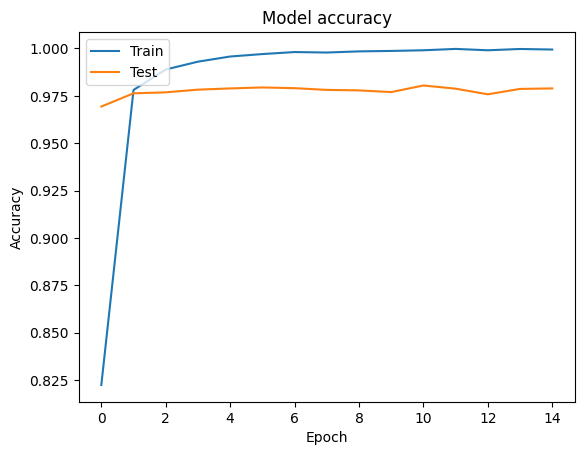

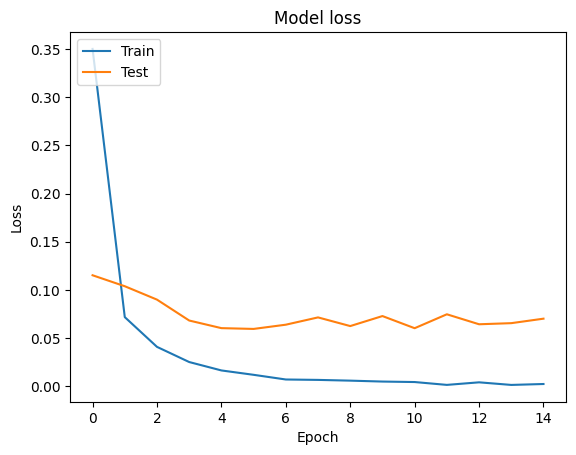

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [31]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9807 - loss: 0.0631
Test Loss: 0.07004626840353012
Test Accuracy: 0.9789133071899414


242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


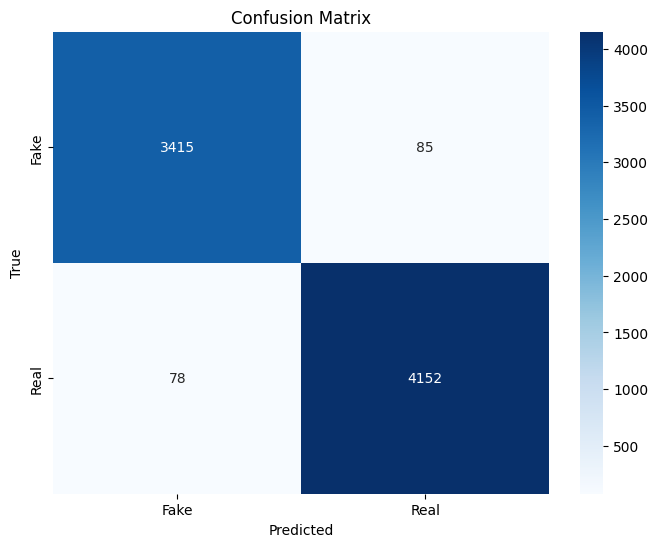

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
from tensorflow.keras.models import save_model

# Assuming 'model' is your Keras model
model.save("/kaggle/working/lstm_model.h5")


In [34]:
model1 = load_model("/kaggle/working/lstm_model.h5")  # Change the path if necessary


def process_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove extra white space from text
        text = re.sub(r'\W', ' ', str(text))  # Remove all the special characters from text
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters from text
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove any character that isn't alphabetical
        text = text.lower()

        return text
    else:
        return ""

# Example text for testing
new_text = "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had."

# Preprocess the new text
cleaned_text = process_text(new_text)

# Tokenizer
tokenizer = Tokenizer()
# Convert X_train to list of strings
X_train_texts = [process_text(text) for text in X_train]
tokenizer.fit_on_texts(X_train_texts)
word_idx = tokenizer.word_index
print("Size of vocabulary:", len(word_idx))

# Convert text to sequences
X_new = tokenizer.texts_to_sequences([cleaned_text])

# Padding sequences to a fixed length
max_sequence_length = 100  # Define your maximum sequence length
X_new = pad_sequences(X_new, maxlen=max_sequence_length)

# Make predictions
y_pred_prob = model1.predict(X_new)
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Assuming 0 represents 'Fake' and 1 represents 'Real'
# You may need to adjust this according to your label encoding
class_labels = ['Fake', 'Real']
predicted_class = class_labels[y_pred_label[0][0]]

# Print prediction
print(f"Predicted Label: {predicted_class}")


NameError: name 'load_model' is not defined

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re

# Load the saved model
model1= load_model("/kaggle/working/lstm_model.h5")  # Change the path if necessary

def process_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text, flags=re.I)  # Remove extra white space from text
        text = re.sub(r'\W', ' ', str(text))  # Remove all the special characters from text
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove all single characters from text
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove any character that isn't alphabetical
        text = text.lower()

        return text
    else:
        return ""

# Example text for testing
new_text = "Donald Trump just couldn't wish all Americans a Happy New Year and leave it at that. Instead, he had."

# Preprocess the new text
cleaned_text = process_text(new_text)

# Tokenizer
tokenizer = Tokenizer()
# Convert X_train to list of strings
X_train_texts = [process_text(text) for text in X_train]
tokenizer.fit_on_texts(X_train_texts)
word_idx = tokenizer.word_index
print("Size of vocabulary:", len(word_idx))

# Convert text to sequences
X_new = tokenizer.texts_to_sequences([cleaned_text])

# Padding sequences to a fixed length
max_sequence_length = 150  # Adjusted maximum sequence length
X_new = pad_sequences(X_new, maxlen=max_sequence_length)

# Make predictions
y_pred_prob = model1.predict(X_new)
y_pred_label = (y_pred_prob > 0.5).astype(int)

# Assuming 0 represents 'Fake' and 1 represents 'Real'
# You may need to adjust this according to your label encoding
class_labels = ['Fake', 'Real']
predicted_class = class_labels[y_pred_label[0][0]]

# Print prediction
print(f"Predicted Label: {predicted_class}")
